In [1]:
import git
import pandas as pd
import numpy as np
import os
import re
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import yfinance as yf
from afinn import Afinn

In [2]:
# Desired absolute folder path where you want the repository
repo_url = "https://github.com/stihem/DS821"
repo_dir = os.path.join(os.path.expanduser("~"), "DS821", "GitHub_repository")

# Ensure the target folder exists
os.makedirs(repo_dir, exist_ok=True)

# Clone only if the repository does not already exist
if not os.path.exists(os.path.join(repo_dir, '.git')):
    git.Repo.clone_from(repo_url, repo_dir)
    print(f"Repository cloned to {repo_dir}")
else:
    print("Repository already exists in the desired directory.")
    
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

Repository already exists in the desired directory.


Importing, structuring and visualising the Reddit WallStreetBets data from Kaggle: https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts

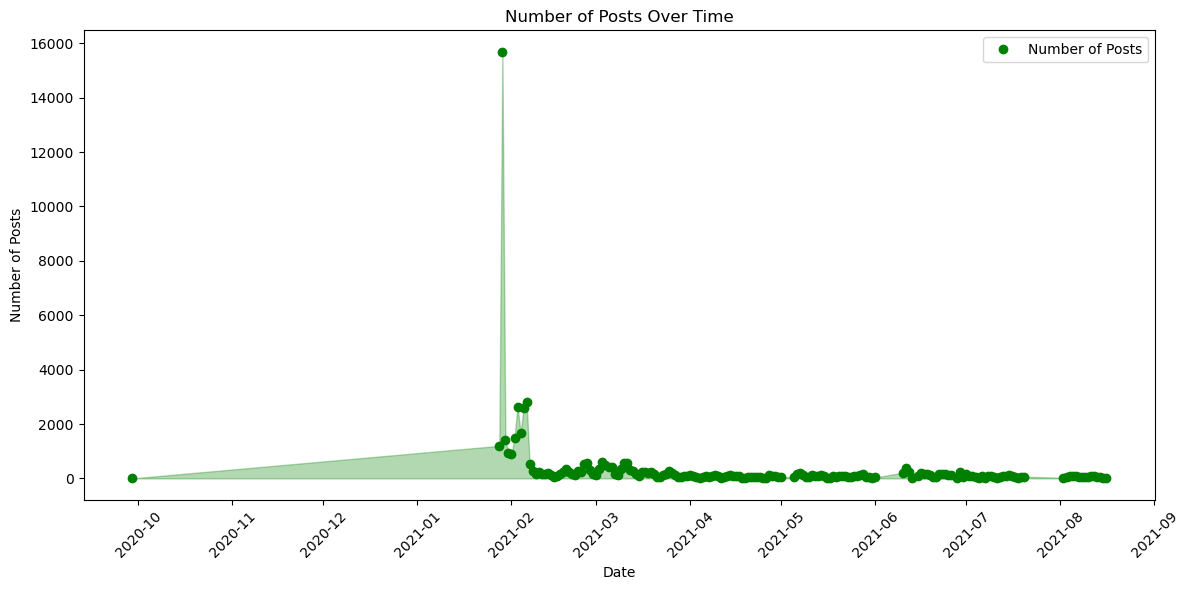

In [3]:
# Define file paths
data_dir = os.getcwd()
data_file = os.path.join(data_dir, 'reddit_wsb.csv')
ticker_file = os.path.join(data_dir, 'cleaned_stock_tickers.csv')

# Load data
data = pd.read_csv(data_file, parse_dates=['timestamp'], infer_datetime_format=True)
data['text_combined'] = data['title'].fillna('') + ' ' + data['body'].fillna('')
data['post_date'] = pd.to_datetime(data['timestamp']).dt.date

# Group data by post_date and count mentions
daily_post_counts = data.groupby('post_date').size().reset_index(name='post_count')

# Create a scatter-style plot with dots only
plt.figure(figsize=(12, 6))  # Set figure size

# Plot only dots (no lines)
plt.plot(daily_post_counts['post_date'], daily_post_counts['post_count'], 
         marker='o', color='green', linestyle='None', label='Number of Posts')

# Add shaded area under the dots (optional for style)
plt.fill_between(daily_post_counts['post_date'], daily_post_counts['post_count'], 
                 color='green', alpha=0.3)

# Customize plot
plt.title("Number of Posts Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()


The graph reveals a single outlier post around 2020-20, which will be removed to ensure cleaner data for analysis. As the majority of activity is concentrated around 2021-02, we will narrow the dataset to the time period from 2021-01-28 to 2021-02-10.

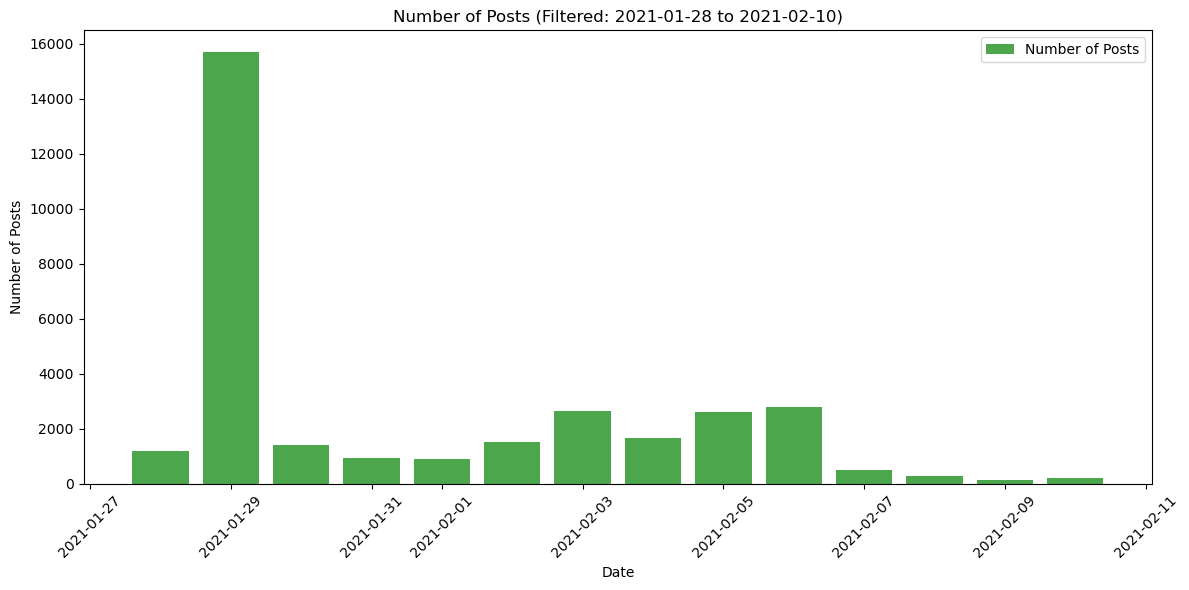

In [4]:
# Filter dataset
start = pd.to_datetime('2021-01-28').date()
end = pd.to_datetime('2021-02-10').date()
data_filtered = data[(data['post_date'] >= start) & (data['post_date'] <= end)]

# Group filtered data by post_date and count mentions
filtered_post_counts = data_filtered.groupby('post_date').size().reset_index(name='post_count')

# Visualization 1: Bar plot for filtered data
plt.figure(figsize=(12, 6))

# Bar plot
plt.bar(filtered_post_counts['post_date'], filtered_post_counts['post_count'], 
        color='green', alpha=0.7, label='Number of Posts')

# Customize plot
plt.title("Number of Posts (Filtered: 2021-01-28 to 2021-02-10)")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.legend(loc='upper right')

plt.show()


To effectively apply the NLP tools, the text needs to be cleaned for handles, URLs, special characters, single letters and extra spaces.

In [5]:
# Clean text function
def preprocess_text(content):
    content = re.sub(r'@[\w]+', '', content)  # Remove handles
    content = re.sub(r'http\S+', '', content)  # Remove URLs
    content = re.sub(r'[^a-zA-Z0-9\s]', '', content)  # Remove special characters
    content = re.sub(r'\b\w\b', '', content)  # Remove single letters
    content = re.sub(r'\s+', ' ', content)  # Remove extra spaces
    return content.strip()

data_filtered['clean_text'] = data_filtered['text_combined'].apply(preprocess_text)

The pre-trained 'en_core_web_sm' NLP model from the spaCy library, designed for natural language processing tasks, is loaded and used to process text data from the clean_text column of the data_filtered DataFrame. The pipe() method efficiently applies the model to each text entry, producing the processed_docs list, which prepares the data for Named Entity Recognition (NER).

In [6]:
# Load NLP model and process text
language_model = spacy.load("en_core_web_sm")
processed_docs = list(language_model.pipe(data_filtered['clean_text']))

The NER process is used to identify "organization" entities, which are then further refined to extract valid stock tickers. This allows the script to count mentions of stock tickers and analyze their frequency across the dataset.

In [7]:
# Load ticker data
ticker_data = pd.read_csv(ticker_file)
tickers = ticker_data['Ticker'].str.upper().tolist()

# Extract stock tickers
def find_tickers(doc):
    return [
        token.text.upper()
        for token in doc
        if (
            token.is_alpha and
            len(token.text) in range(2, 6) and
            token.ent_type_ == 'ORG' and
            token.text.upper() in tickers
        )
    ]
data_filtered['extracted_tickers'] = [find_tickers(doc) for doc in processed_docs]

# Count mentions
def ticker_counter(ticker_list):
    ticker_flat = [ticker for sublist in ticker_list for ticker in set(sublist)]
    return dict(Counter(ticker_flat))

mention_count = ticker_counter(data_filtered['extracted_tickers'])
mention_df = pd.DataFrame.from_dict(mention_count, orient='index', columns=['mentions']).reset_index()
mention_df.columns = ['ticker', 'total_mentions']
mention_df = mention_df.sort_values(by='total_mentions', ascending=False)
top_tickers = mention_df.head(3)['ticker'].tolist()

# Explode tickers into rows
expanded_data = data_filtered.explode('extracted_tickers')
expanded_data = expanded_data.rename(columns={'extracted_tickers': 'ticker'})

# Count daily mentions
daily_mentions = expanded_data.groupby(['post_date', 'ticker']).size().reset_index(name='mention_count')

Denifing a plot function which shows the number of mentions for a ticker with a day's moving average as well as the stock price with a day's
moving average for the top 3 most mentioned tickers: GME, AMC and NOK.

[*********************100%***********************]  1 of 1 completed


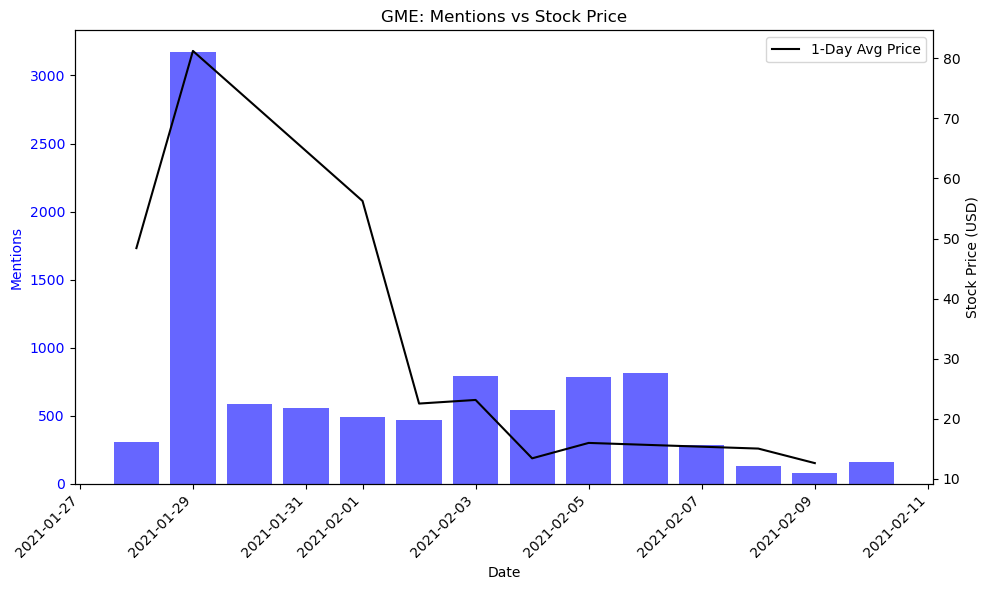

[*********************100%***********************]  1 of 1 completed


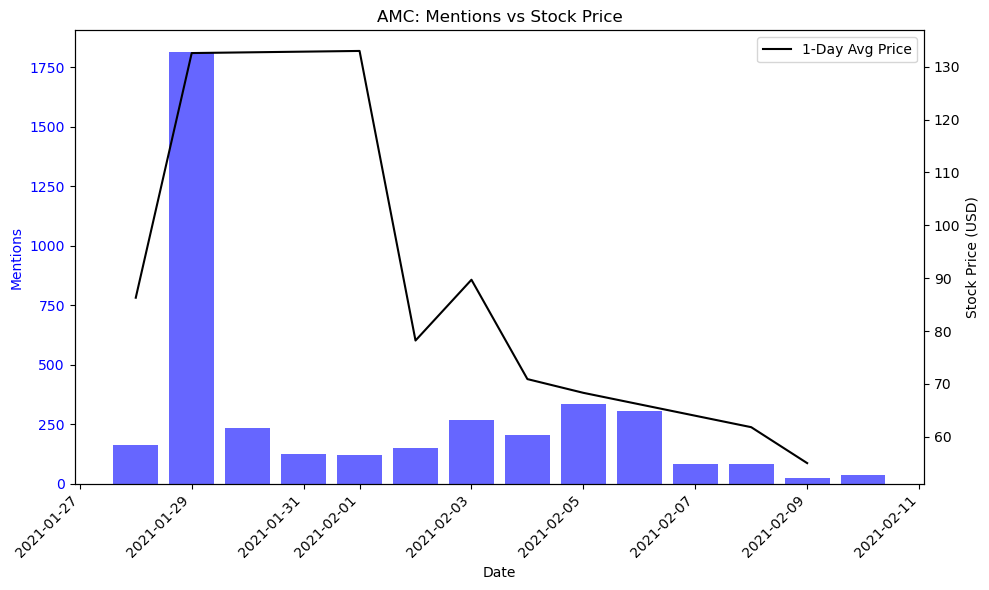

[*********************100%***********************]  1 of 1 completed


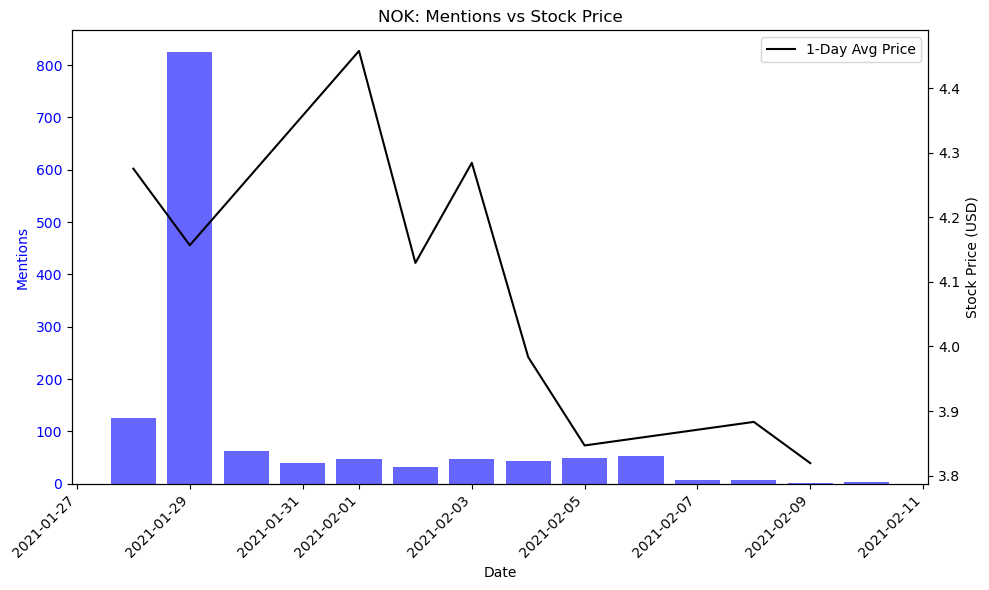

In [8]:
# Plot function
def visualize_ticker_activity(ticker):
    ticker_data = daily_mentions[daily_mentions['ticker'] == ticker]
    ticker_data.set_index('post_date', inplace=True)
    ticker_data['1d_mention_avg'] = ticker_data['mention_count'].rolling(1).mean()

    stock_history = yf.download(ticker, start=ticker_data.index.min(), end=ticker_data.index.max())
    stock_history['1d_price_avg'] = stock_history['Adj Close'].rolling(1).mean()

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.bar(ticker_data.index, ticker_data['1d_mention_avg'], color='blue', alpha=0.6, label='1-Day Avg Mentions')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mentions', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(stock_history.index, stock_history['1d_price_avg'], color='black', label='1-Day Avg Price')
    ax2.set_ylabel('Stock Price (USD)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    plt.title(f'{ticker}: Mentions vs Stock Price')

    # Explicitly set x-axis label rotation
    fig.autofmt_xdate(rotation=45)

    fig.tight_layout()
    plt.legend(loc='upper right')
    plt.show()

# Visualize results
for ticker in top_tickers:
    visualize_ticker_activity(ticker)

The graphs above display only the frequency of mentions for the given stocks. To analyze the sentiment associated with these mentions, a basic sentiment analysis is conducted using the AFINN lexicon. This analysis is combined with stock prices smoothed using a one-day moving average for the top 3 most mentioned tickers: GME, AMC, and NOK.

Top 3 Tickers based on mention counts: ['GME', 'AMC', 'NOK']


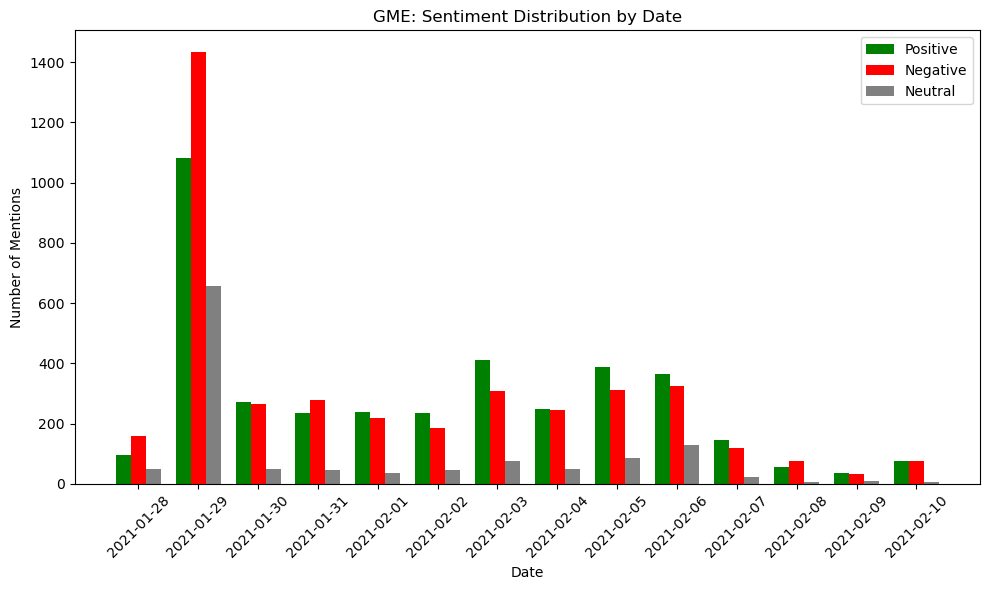

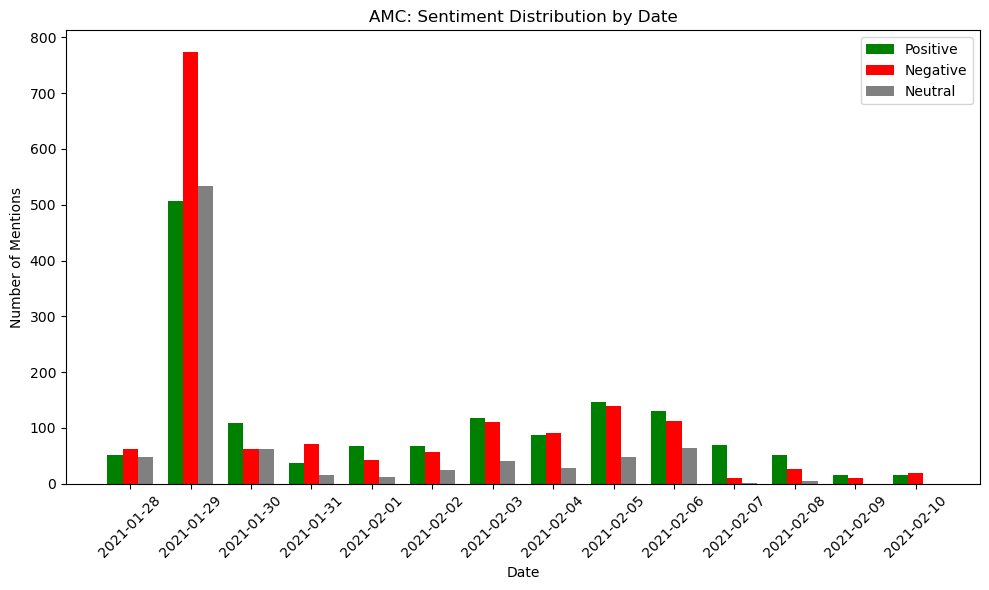

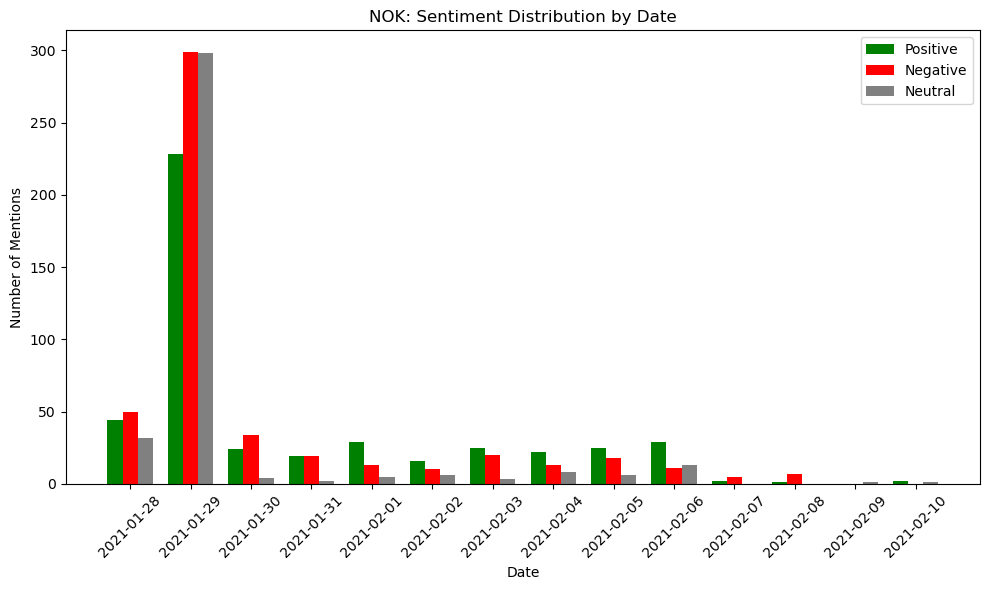

[*********************100%***********************]  1 of 1 completed


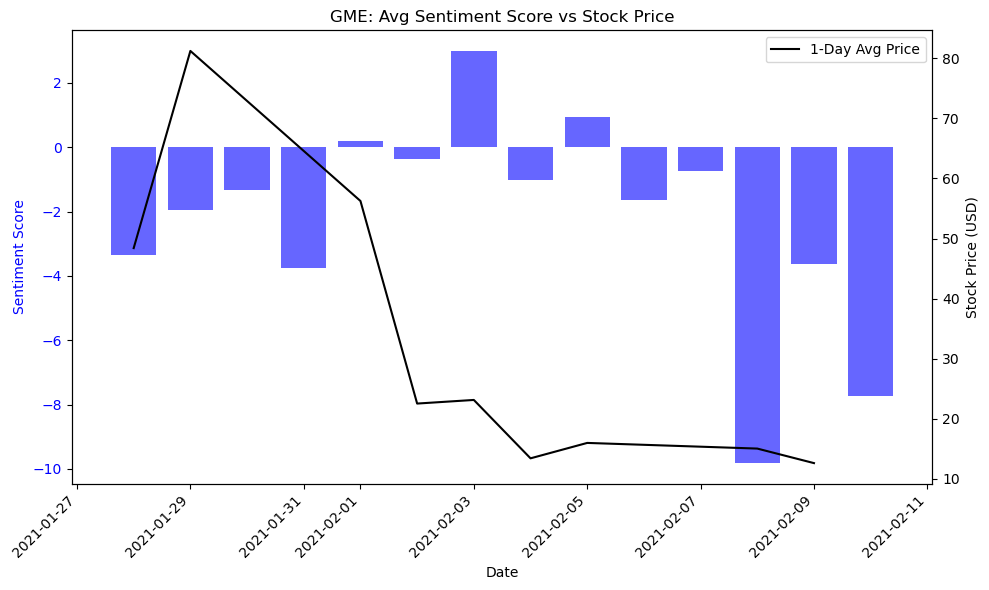

[*********************100%***********************]  1 of 1 completed


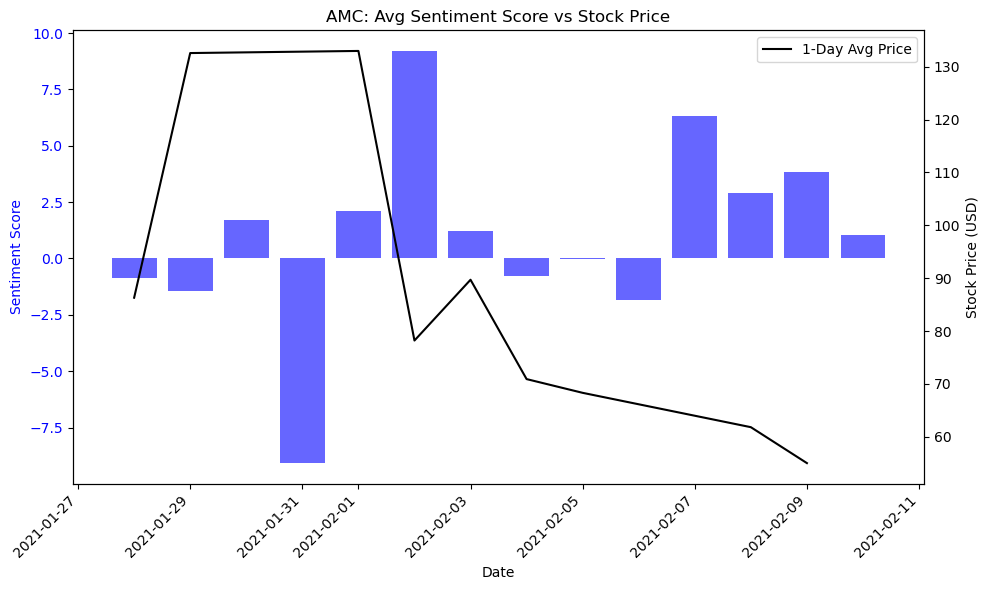

[*********************100%***********************]  1 of 1 completed


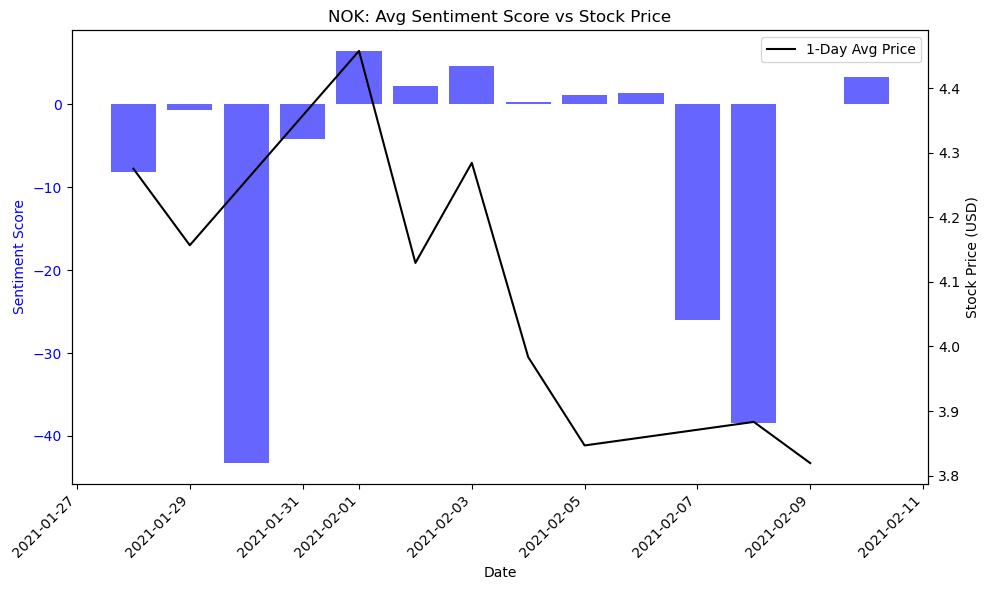

In [9]:
# Initialize AFINN for sentiment analysis
afinn = Afinn()

# Dynamically select top tickers based on mention counts
ticker_mentions = expanded_data['ticker'].value_counts()
top_tickers = ticker_mentions.head(3).index.tolist()
print(f"Top 3 Tickers based on mention counts: {top_tickers}")

# Ensure post_date is in datetime format
expanded_data['post_date'] = pd.to_datetime(expanded_data['post_date'], errors='coerce')

# Extract sentiment scores for posts mentioning top tickers
def analyze_sentiment(row):
    if row['ticker'] in top_tickers:  # Focus on top 3 tickers only
        return afinn.score(row['clean_text'])
    return None

expanded_data['sentiment_score'] = expanded_data.apply(analyze_sentiment, axis=1)
expanded_data = expanded_data.dropna(subset=['sentiment_score'])

# Categorize sentiment into Positive, Negative, and Neutral
def categorize_sentiment(score):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

expanded_data['sentiment_category'] = expanded_data['sentiment_score'].apply(categorize_sentiment)

# Filter for top tickers and sentiment
filtered_sentiment = expanded_data[expanded_data['ticker'].isin(top_tickers)]

# Plot sentiment distribution per ticker (Triple Bar Chart for Each Date)
for ticker in top_tickers:
    # Filter data for the specific ticker
    ticker_data = filtered_sentiment[filtered_sentiment['ticker'] == ticker]
    
    # Group by date and sentiment category, then count occurrences
    sentiment_grouped = ticker_data.groupby(['post_date', 'sentiment_category']).size().unstack(fill_value=0)
    
    # Sort by date to ensure the x-axis is in order
    sentiment_grouped = sentiment_grouped.sort_index()
    
    # Extract Positive, Negative, and Neutral counts, fill missing categories with 0
    positive_counts = sentiment_grouped.get('Positive', 0)
    negative_counts = sentiment_grouped.get('Negative', 0)
    neutral_counts = sentiment_grouped.get('Neutral', 0)

    # Set bar positions for grouped display
    x = np.arange(len(sentiment_grouped.index))  # the label locations
    bar_width = 0.25  # width of each bar

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - bar_width, positive_counts, width=bar_width, color='green', label='Positive')
    ax.bar(x, negative_counts, width=bar_width, color='red', label='Negative')
    ax.bar(x + bar_width, neutral_counts, width=bar_width, color='grey', label='Neutral')

    # Labeling and Formatting
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Mentions')
    ax.set_title(f'{ticker}: Sentiment Distribution by Date')
    ax.set_xticks(x)
    ax.set_xticklabels(sentiment_grouped.index.strftime('%Y-%m-%d'), rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Combine sentiment analysis with stock price data and mentions
def visualize_ticker_activity_with_sentiment(ticker):
    # Filter data for the specific ticker
    ticker_data = filtered_sentiment[filtered_sentiment['ticker'] == ticker]
    ticker_data = ticker_data.groupby('post_date')[['sentiment_score']].mean().reset_index()
    ticker_data.set_index('post_date', inplace=True)

    # Fetch stock price history
    stock_history = yf.download(ticker, start=ticker_data.index.min(), end=ticker_data.index.max())
    stock_history['1d_price_avg'] = stock_history['Adj Close'].rolling(1).mean()

    # Plot sentiment and stock price
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.bar(ticker_data.index, ticker_data['sentiment_score'], color='blue', alpha=0.6, label='Avg Sentiment Score')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sentiment Score', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(stock_history.index, stock_history['1d_price_avg'], color='black', label='1-Day Avg Price')
    ax2.set_ylabel('Stock Price (USD)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    plt.title(f'{ticker}: Avg Sentiment Score vs Stock Price')

    # Explicitly set x-axis label rotation
    fig.autofmt_xdate(rotation=45)

    fig.tight_layout()
    plt.legend(loc='upper right')
    plt.show()

# Visualize combined results for each top ticker
for ticker in top_tickers:
    visualize_ticker_activity_with_sentiment(ticker)
